## Vehicle Detection and Tracking Project

### Project Details
For this project, a labeled dataset was provide and my job is to decide what features to extract, then train a classifier and ultimately track vehicles in a video stream. Here are links to the labeled data for [vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and [non-vehicle](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip) examples to train your classifier. These example images come from a combination of the [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html), the [KITTI vision benchmark suite](http://www.cvlibs.net/datasets/kitti/), and examples extracted from the project video itself.

Udacity recently released a labeled dataset which can be used to take advantage of to augment the training data. The Udacity data can find [here](https://github.com/udacity/self-driving-car/tree/master/annotations). In each of the folders containing images there's a csv file containing all the labels and bounding boxes. To add vehicle images to the training data, we can use the csv files to extract the bounding box regions and scale them to the same size as the rest of the training images.

The project video will be the same one as for the Advanced Lane Finding Project. 

The goals / steps of this project are the following:

Pipeline (single images)
* [Step 1](#step1): Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images. Optionally, apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector. 
* [Step 2](#step2): Normalize the features and randomize a selection for training and testing.
* [Step 3](#step3): Train a classifier using Linear SVM classifier with extracted features.
* [Step 4](#step4): Implement a sliding-window technique and use trained classifier to search for vehicles in images.
* [Step 5](#step5): Multiple Detections & False Positives
* [Step 6](#step6): Estimate a bounding box for vehicles detected.

Video Implementation

Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4


---
## Pipeline (single images)

### Import necessary  libraries and packages

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

from skimage.feature import hog
from scipy.ndimage.measurements import label

import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


<a id='step1'></a>
### Step 1 Histogram of Oriented Gradients (HOG)


For vehicle detection and tracking, I needed to extract features from training dataset which used for training process later. I started by reading in all the `vehicle` and `non-vehicle` images, exploring the dataset, and displaying an example of one of each of the vehicle and non-vehicle classes as below:

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


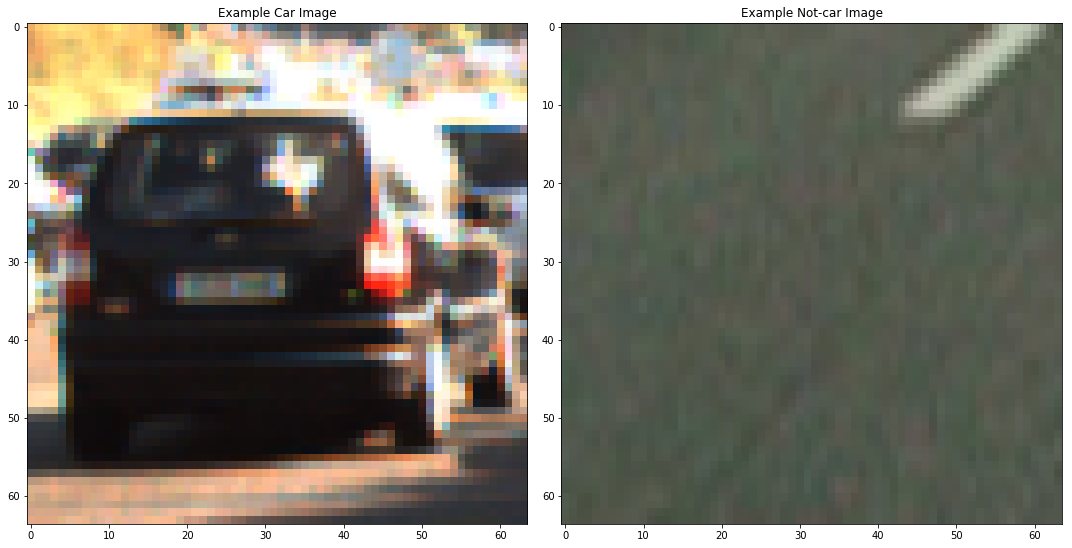

In [2]:
# Read in car and non-car images
cars = []
images = glob.glob('../../P5_Data/vehicles/**/*.png', recursive=True)
for image in images:
    cars.append(image)
    
notcars = []
images = glob.glob('../../P5_Data/non-vehicles/**/*.png', recursive=True)
for image in images:
    notcars.append(image)

# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# choose random car / not-car indices and plot example images 
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
fig.tight_layout()


I then explored different color spaces and different [`skimage.hog()`](http://scikit-image.org/docs/stable/api/skimage.feature.html?highlight=hog#skimage.feature.hog) parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.


/Users/phuongpham/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


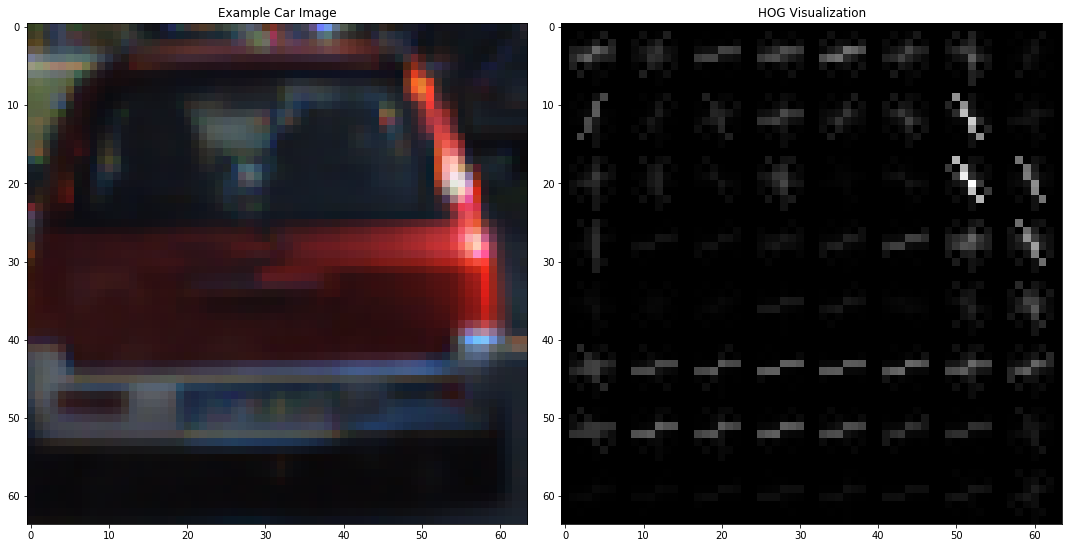

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec, block_norm='L2-Hys')
        return features

# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)


# Plot the examples
fig = plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
fig.tight_layout()

The `skimage.hog()` function takes in a single color channel or grayscaled image as input, as well as various parameters. These parameters include `orientations`, `pixels_per_cell` and `cells_per_block`.

The value of `orientations` is the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.

The `pixels_per_cell` parameter specifies the cell size over which each gradient histogram is computed. This paramater is commonly seleted as a 2-tuple so that the cells would be square. 

The `cells_per_block` parameter is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. Block normalization is not necessarily required, but generally leads to a more robust feature set.

![alt text](./examples/hog-visualization1.jpg)*Source: From Udacity lecture*

There is another optional power law or "gamma" normalization scheme set by the flag `transform_sqrt`. This type of normalization may help reduce the effects of shadows or other illumination variation, but will cause an error if the image contains negative values (because it's taking the square root of image values).

The HOG visualization is a representation that shows the dominant gradient direction within each cell with brightness corresponding to the strength of gradients in that cell.


Here is an example using the YCrCb color space and HOG parameters of orientations=9, pixels_per_cell=(8, 8) and cells_per_block=(2, 2)

/Users/phuongpham/anaconda3/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


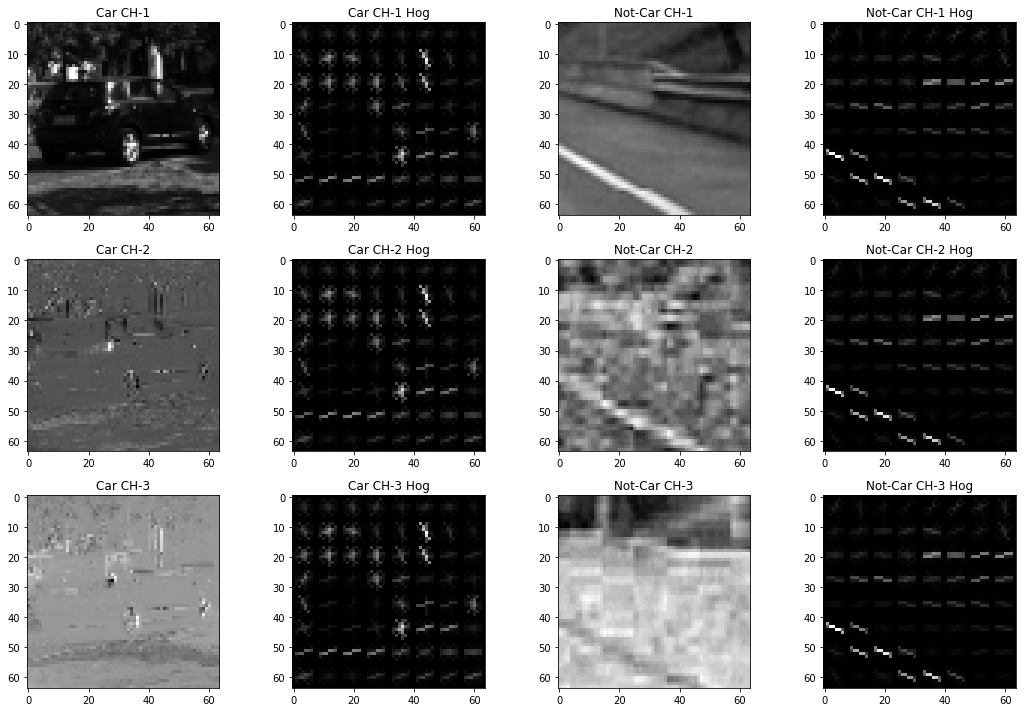

In [4]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
Y_channel = YCrCb[:,:,0]
Cr_channel = YCrCb[:,:,1]
Cb_channel = YCrCb[:,:,2]

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features_1, hog_image_1 = get_hog_features(Y_channel, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
features_2, hog_image_2 = get_hog_features(Y_channel, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
features_3, hog_image_3 = get_hog_features(Y_channel, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure(figsize=(15,10))        
plt.subplot(3,4,1)
plt.imshow(Y_channel, cmap='gray')
plt.title('Car CH-1')
plt.subplot(3,4,2)
plt.imshow(hog_image_1, cmap='gray')
plt.title('Car CH-1 Hog')
plt.subplot(3,4,5)
plt.imshow(Cr_channel, cmap='gray')
plt.title('Car CH-2')
plt.subplot(3,4,6)
plt.imshow(hog_image_2, cmap='gray')
plt.title('Car CH-2 Hog')
plt.subplot(3,4,9)
plt.imshow(Cb_channel, cmap='gray')
plt.title('Car CH-3')
plt.subplot(3,4,10)
plt.imshow(hog_image_3, cmap='gray')
plt.title('Car CH-3 Hog')

image = mpimg.imread(notcars[ind])
YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
Y_channel = YCrCb[:,:,0]
Cr_channel = YCrCb[:,:,1]
Cb_channel = YCrCb[:,:,2]

# Call our function with vis=True to see an image output
features_1, hog_image_1 = get_hog_features(Y_channel, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
features_2, hog_image_2 = get_hog_features(Y_channel, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
features_3, hog_image_3 = get_hog_features(Y_channel, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
      
plt.subplot(3,4,3)
plt.imshow(Y_channel, cmap='gray')
plt.title('Not-Car CH-1')
plt.subplot(3,4,4)
plt.imshow(hog_image_1, cmap='gray')
plt.title('Not-Car CH-1 Hog')
plt.subplot(3,4,7)
plt.imshow(Cr_channel, cmap='gray')
plt.title('Not-Car CH-2')
plt.subplot(3,4,8)
plt.imshow(hog_image_2, cmap='gray')
plt.title('Not-Car CH-2 Hog')
plt.subplot(3,4,11)
plt.imshow(Cb_channel, cmap='gray')
plt.title('Not-Car CH-3')
plt.subplot(3,4,12)
plt.imshow(hog_image_3, cmap='gray')
plt.title('Not-Car CH-3 Hog')
fig.tight_layout()

#### Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector.

More features such as such as spatial binned color and histograms of color were extracted and combined to HOG features.


In [12]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial(), color_hist() and get_hog_features()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


I tried various combinations of parameters and extracted features for further classification. Below is my final choice of parameters which gave the good results in vehicle detection steps later on.

In [6]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

# Extract features
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

230.18 Seconds to extract features...


<a id='step2'></a>
### Step 2 Normalize the features and randomize a selection for training and testing.

After gaining features from previous steps, it was neccessary to normalize the data before applying any machine learning algorithms. I used [`StandardScaler()`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) method from [`sklearn`](http://scikit-learn.org/stable/index.html) for nomalization.

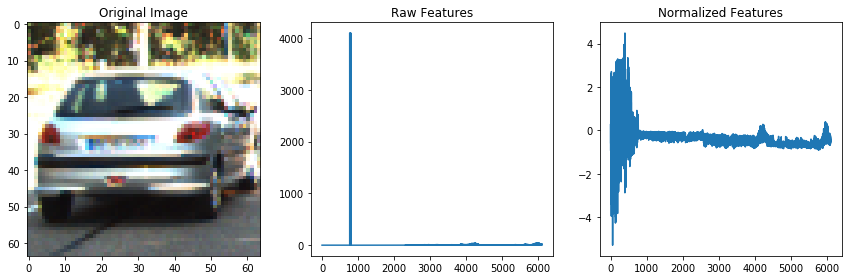

In [7]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
     
    # Plot an example of raw and scaled features
    car_ind = np.random.randint(0, len(cars))
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

The above plots showed the raw features and normalized features extracted from a random car image.

Then the nomalized data was randomly splitted into training and test sets as below.

In [8]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


<a id='step3'></a>
### Step 3 Train a classifier using Linear SVM classifier with extracted features.

I trained a linear SVM using selected HOG features and color features.

#### Define a Performance Metric
For the performance_metric function in the code cell below, I used r2_score from `sklearn.metrics` to perform a performance calculation between y_true and y_predict. Assign the performance score to the score variable.

In [9]:
# TODO: Import 'r2_score'
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    # TODO: Calculate the performance score between 'y_true' and 'y_predict'
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

#### Evaluating Model Performance Using Grid Search and Cross-Validation
Hyper-parameters are parameters that are not directly learnt within estimators. In scikit-learn they are passed as arguments to the constructor of the estimator classes. Typical examples include C, kernel and gamma for Support Vector Classifier. It is possible and recommended to search the hyper-parameter space for the best performance score of the learning algorithm. Generally, a search consists of:
- an estimator (regressor or classifier such as sklearn.svm.SVC());
- a parameter space;
- a method for searching or sampling candidates;
- a cross-validation scheme; and
- a score function.

A generic approach to sampling search candidates (provided in scikit-learn) is grid search, considers all parameter combinations. In scikit-learn, the grid search provided by GridSearchCV exhaustively generates candidates from a grid of parameter values specified with the param_grid parameter. The GridSearchCV instance then are input to contruct the models. The fitting models of all the possible combinations of parameter values are evaluated and the best combination is retained.

In [11]:
from sklearn.metrics import make_scorer 
from sklearn.model_selection import GridSearchCV 
from sklearn.cross_validation import ShuffleSplit

def fit_model(X, y):
    """ Performs grid search over the 'C' parameter for a 
        SVM trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    # sklearn version 0.18: ShuffleSplit(n_splits=10, test_size=0.1, train_size=None, random_state=None)
    # sklearn versiin 0.17: ShuffleSplit(n, n_iter=10, test_size=0.1, train_size=None, random_state=None)
    random_state = np.random.randint(0, 100)
    cv_sets = ShuffleSplit(X.shape[0], n_iter=5, test_size=0.20, random_state=random_state)

    # TODO: Create a decision tree regressor object
    svc = SVC(random_state=random_state)

    # TODO: Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'C': [1, 10], 'kernel': ['rbf', 'linear']}

    # TODO: Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # TODO: Create the grid search object
    grid = GridSearchCV(svc, params, scoring=scoring_fnc, cv=cv_sets) 

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

# Fit the training data to the model using grid search
result = fit_model(X_train, y_train)
print(result)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=25, shrinking=True,
  tol=0.001, verbose=False)


The best result after grid search( C=10, kernel='rbf') were selected for training and testing.

In [14]:
# Use a SVC 
random_state = np.random.randint(0, 100)
svc = SVC(C=10,kernel='rbf', random_state=random_state)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

161.2 Seconds to train SVC...
Test Accuracy of SVC =  0.9938
My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  0.  0.  1.  1.  0.  1.]
0.15954 Seconds to predict 10 labels with SVC


##### <a id='step4'></a>
### Step 4 Sliding Window Search

I started with sliding window search which searched over all the windows defined by `slide_windows()` with window size was (96, 96) pixels and overlap 50% of the windows, extracted features at each window position, and predicted with the classifier on each set of features.

In [17]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

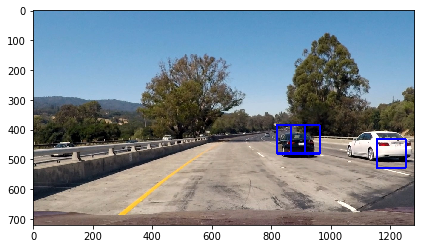

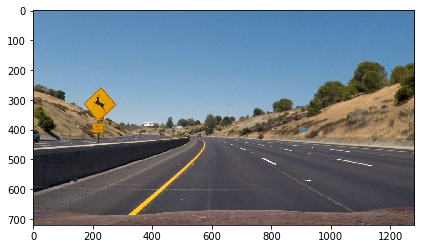

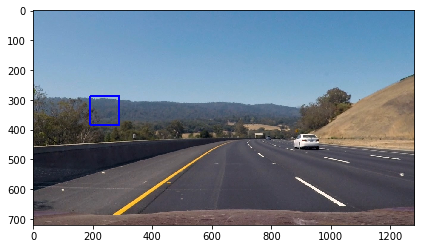

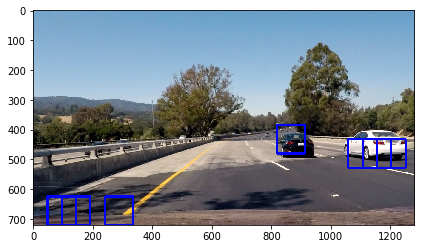

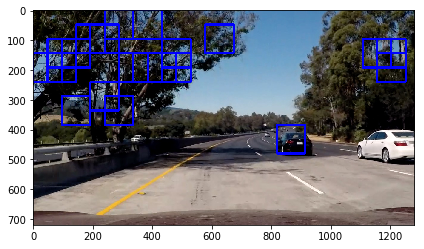

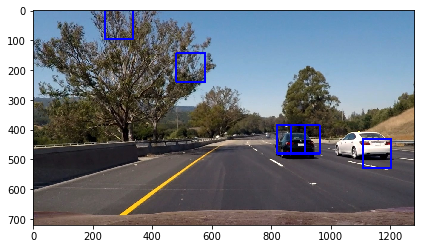

In [18]:
images = glob.glob('./test_images/*.jpg')

for fname in images:
    image = mpimg.imread(fname)

    draw_image = np.copy(image)
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    fig = plt.figure()
    plt.imshow(window_img)
    fig.tight_layout()

The sliding window approach detected cars in the images but still found some false positives in the skies and treetops. So I used Hog Sub-Sampling Window Search implemented with `find_cars()` function to extract hog features once and then sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%. To remove the false positives in the skies and treetops, I limited the search area from y_start to y_stop. I ran this `find_cars()` function multiple times for different scale values to generate multiple-scaled search windows.
![alt text](./examples/hog-sub.jpg)*Source: From Udacity lecture*

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector.



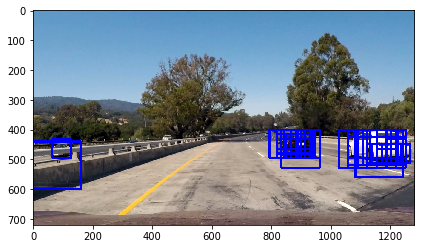

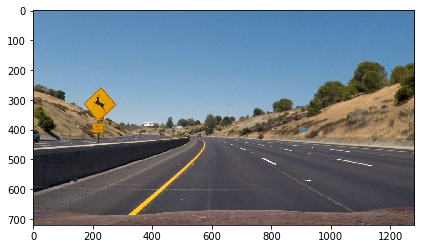

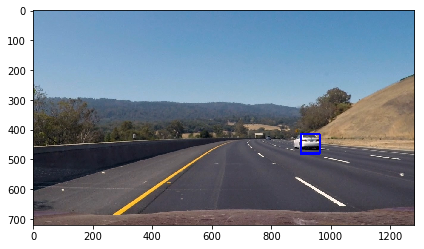

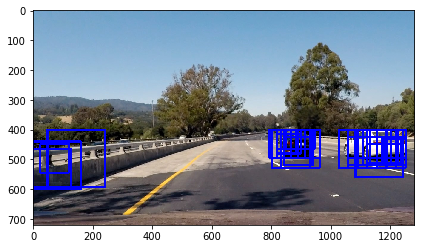

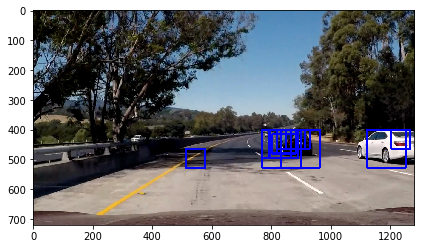

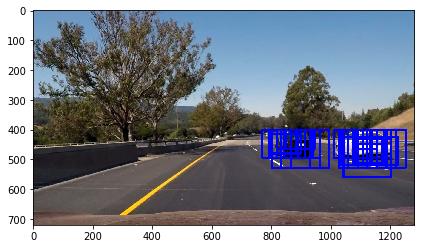

In [20]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bboxes = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bboxes.append(bbox)
    return draw_img, bboxes
    
y_start = 400
y_stop = 656
scales = [1, 1.5, 2, 2.5, 3]

images = glob.glob('./test_images/*.jpg')

for fname in images:
    image = mpimg.imread(fname)

    box_list = []
    for scale in scales: 
        out_img, boxes = find_cars(image, y_start, y_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list = box_list + boxes
    draw_image = np.copy(image)
    out_img = draw_boxes(draw_image, box_list, color=(0, 0, 255), thick=6)
    
    fig = plt.figure()
    plt.imshow(out_img)
    fig.tight_layout()

<a id='step5'></a>
### Step 5 Multiple Detections & False Positives

The Window Search methods and predictions returned positive detections for each images. From the positive detections I created a heatmap by adding "heat" (+=1) to a map for a list of bounding boxes and then thresholded that map to identify vehicle positions and remove false positives. 

I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap. I then assumed each blob corresponded to a vehicle. 

In [22]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

<a id='step6'></a>
### Step 6 Estimate a bounding box for vehicles detected.

I constructed bounding boxes to cover the area of each blob detected.




In [23]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Here's an example result showing the heatmap from testing images, the result of `scipy.ndimage.measurements.label()` and the bounding boxes:

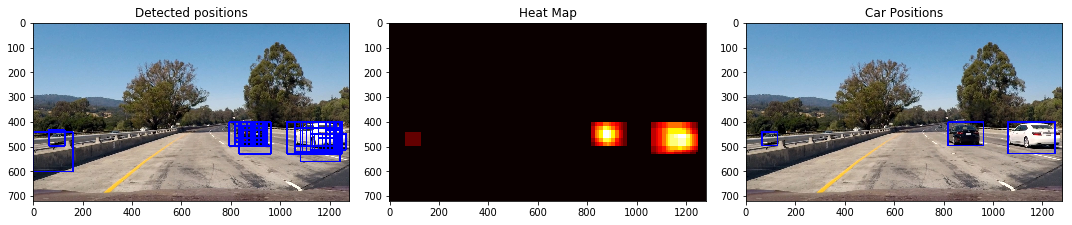

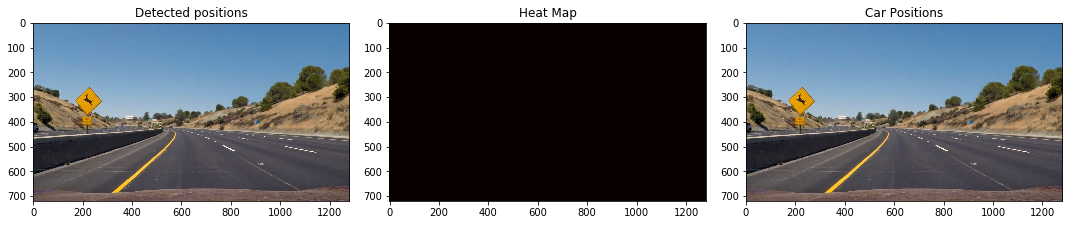

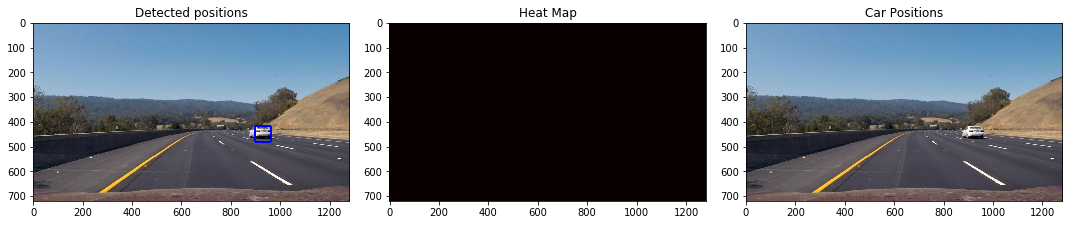

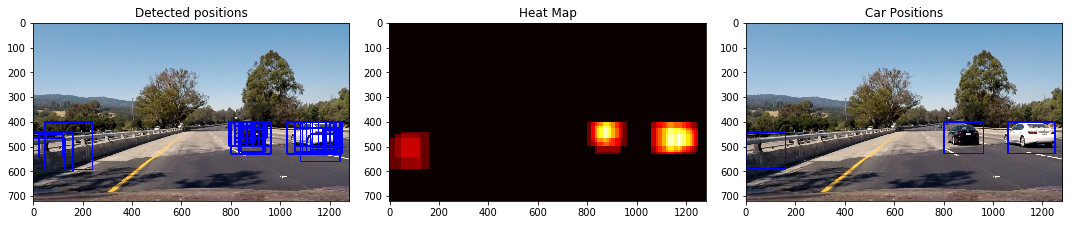

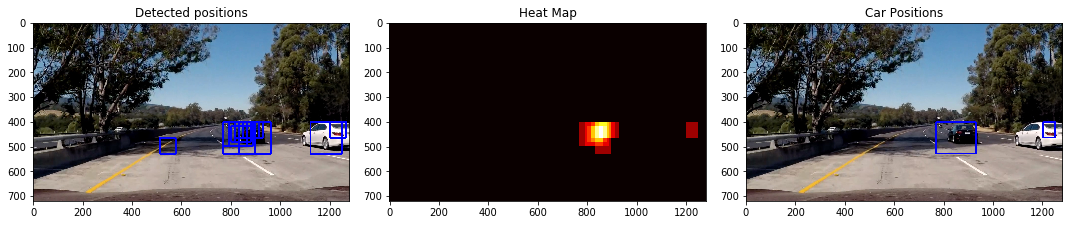

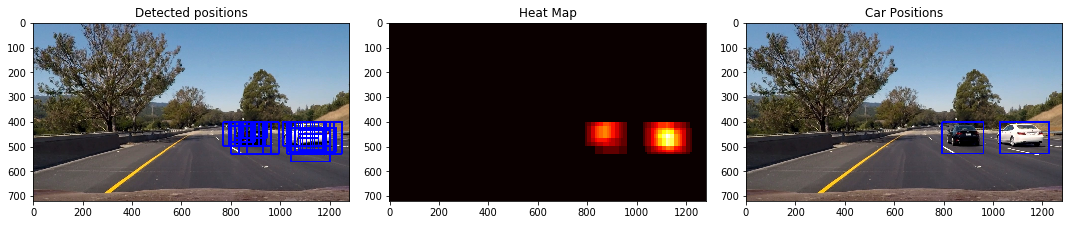

In [24]:
y_start = 400
y_stop = 656
scales = [1, 1.5, 2, 2.5, 3]

images = glob.glob('./test_images/*.jpg')

for fname in images:
    image = mpimg.imread(fname)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    box_list = []
    for scale in scales: 
        out_img, boxes = find_cars(image, y_start, y_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list = box_list + boxes
        
    positions_img = draw_boxes(np.copy(image), box_list, color=(0, 0, 255), thick=6)
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    fig = plt.figure(figsize=(15,15))
    plt.subplot(131)
    plt.imshow(positions_img)
    plt.title('Detected positions')
    plt.subplot(132)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(133)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    fig.tight_layout()

---
## Video Implementation


For a video stream, I run the pipeline and integrate a heat map over several frames of video, such that areas of multiple detections get "hot", while transient false positives stay "cool". I can then simply threshold my heatmap to remove false positives.


In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [26]:
import imageio
imageio.plugins.ffmpeg.download()

In [66]:
def process_frame(img):
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Find bounding boxes of current frame
    box_list = []
    for scale in scales: 
        out_img, boxes = find_cars(img, y_start, y_stop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        box_list = box_list + boxes

    # Add bounding boxes of current frame to buffer
    global box_buffer 
    box_buffer.append(box_list)

    # Get only last nb_frames frames to build heatmap
    tmp_box_list = box_buffer[-nb_frames:]
    new_box_list = []
    for tmp in tmp_box_list:
        new_box_list = new_box_list + tmp
    
    # Add heat to each box in box list
    heat = add_heat(heat,new_box_list)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    #avg_heatmap= new_frame_factor * heatmap + (1-new_frame_factor) * avg_heatmap

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img



Below are the video results with different scales settings. The former is set with only one scale = 1.5. The latter is run multi-scale at 1 and 1.5. The multi-scaled video gave better detection and tracking result. Still, there is room for improvements by twisting parameters such as threshold of the heatmap, number of frames for intergrating the heatmap.

In [70]:
ystart = 400
ystop = 656
scales = [1.5]
box_buffer = []
heat_threshold = 5
nb_frames = 5

In [71]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
in_vid = './project_video.mp4'
out_vid = './project_video_out_3.mp4'

clip = VideoFileClip(in_vid)
video_clip = clip.fl_image(process_frame)
%time video_clip.write_videofile(out_vid, audio=False)

[MoviePy] >>>> Building video ./project_video_out_3.mp4
[MoviePy] Writing video ./project_video_out_3.mp4



 12%|█▏        | 147/1261 [10:22<1:21:58,  4.41s/it]


 23%|██▎       | 293/1261 [20:12<1:01:31,  3.81s/it]


 35%|███▌      | 443/1261 [29:49<51:58,  3.81s/it]


 47%|████▋     | 594/1261 [39:20<41:42,  3.75s/it]


 59%|█████▉    | 745/1261 [49:10<32:40,  3.80s/it]


 71%|███████   | 896/1261 [59:22<24:10,  3.97s/it]


 83%|████████▎ | 1041/1261 [1:08:47<14:17,  3.90s/it]


 94%|█████████▍| 1184/1261 [1:18:04<04:59,  3.90s/it]


100%|█████████▉| 1260/1261 [1:23:01<00:03,  3.89s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out_3.mp4 

CPU times: user 1h 22min 21s, sys: 49 s, total: 1h 23min 10s
Wall time: 1h 23min 2s


In [72]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">4
</video>
""".format(out_vid))

In [76]:
ystart = 400
ystop = 656
scales = [1, 1.5]
box_buffer = []
heat_threshold = 5
nb_frames = 5

In [77]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
in_vid = './project_video.mp4'
out_vid = './project_video_out_2.mp4'

clip = VideoFileClip(in_vid)
video_clip = clip.fl_image(process_frame)
%time video_clip.write_videofile(out_vid, audio=False)

[MoviePy] >>>> Building video ./project_video_out_2.mp4
[MoviePy] Writing video ./project_video_out_2.mp4



 12%|█▏        | 147/1261 [36:54<4:38:46, 15.01s/it]


 23%|██▎       | 291/1261 [1:13:54<4:01:51, 14.96s/it]


 34%|███▍      | 432/1261 [1:49:08<3:27:08, 14.99s/it]


 45%|████▌     | 573/1261 [2:24:19<2:51:31, 14.96s/it]


 57%|█████▋    | 714/1261 [2:59:58<2:16:12, 14.94s/it]


 68%|██████▊   | 855/1261 [3:37:29<1:52:44, 16.66s/it]


 79%|███████▉  | 996/1261 [4:17:13<1:11:02, 16.08s/it]


 90%|█████████ | 1138/1261 [4:56:04<32:11, 15.71s/it]


100%|█████████▉| 1260/1261 [5:29:16<00:17, 17.97s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out_2.mp4 

CPU times: user 5h 26min 53s, sys: 2min 11s, total: 5h 29min 5s
Wall time: 5h 29min 17s


In [78]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">4
</video>
""".format(out_vid))

---
## Discussion
Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.

The pipeline successfully detected and tracked the vehicle of the project video. During the implemetation, there are some problems that I faced in my implementation.
- Some vehicles from far end were not detected and false positive detections still existed, especially in frames with shadows. This could be improved with better training process, such as using larger training dataset, or adjusting smaller scale during window search proccess. 
- Hog feature extraction and window search took a lot of time, especially if I increase # of scales to be searched. This make the pipeline unapplicable in real-time processing. I need to find different feature extraction which take less time to improve the process performance.
- Wobby bounding box found during frames. I improved this problem by integrating a heat map over several frames of video.
- I'm still not happy with the result of the project but the time is limited. I might try different approach such as appling convolution neural network with transfer learning parameters from pre-trained such as ResNet-50 for detecting and tracking vehicles. Two successful real-time object detection frameworks that I could refer are [YOLO](https://arxiv.org/abs/1506.02640) and [SSD](https://arxiv.org/abs/1512.02325)